<a href="https://colab.research.google.com/github/sebastiantonn/phd/blob/main/chapter3/240125_S3_TRAIN_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import random
import tensorflow
import tensorflow.keras as keras  # https://keras.io/api/
from tensorflow.keras.preprocessing import image  # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image
from tensorflow.keras.preprocessing.image import ImageDataGenerator #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
                                                                           # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt  # https://matplotlib.org/stable/api/index
import matplotlib.image as img   # not necessary unless you will manipulate individual images
import shutil # for copying files
import zipfile
import os
from PIL import Image
import re

In [ ]:
# Define parameters

# Set number of tiles to use for training-validation
tilenumber = 7500 #14449

# Set file prefix to be used for saving all output
prefix = "240225-05"

# Define the seed value for random functions
seedint = 64 #17 #42  #64

# Define number of leaf discs used for training-validation
train_val = 25

In [ ]:
# Set the seed for all random functions.
# Setting the seed value allows for increased (but not complete) reproducibility between training sessions,
# so DO NOT CHANGE the seed_value if you want reproducible sessions.
# The use of GPU during training prevents complete reproducibility.
# https://www.kaggle.com/lbronchal/keras-gpu-cpu-reproducibility-test
tensorflow.random.set_seed(seedint) # Define the seed value for tensorflow
np.random.seed(seedint)  # Define the seed value for numpy
random.seed(seedint) # Define the seed value for python's built-in 'random' module

In [ ]:
# Set directory for saving model, model weights and plots
outputdirectory = prefix + '_trypan-blue_VGG16_adamax_AP60-checkpoints'

if not os.path.isdir(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory)):
  os.mkdir(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory))

In [ ]:
# Point the zipfile.ZipFile module towards the zipped folder of interest and open it in read mode.
# (https://docs.python.org/3/library/zipfile.html)
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/PhD/TrypanBlue/tiles_resorted_two-classes.zip", 'r')

# Extract the contents of the zipped folder to the 'content' folder of Colab.
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
# Read in list of leafdisc files to include
leafdisc_list_path = '/content/drive/MyDrive/PhD/TrypanBlue/240119_leafdisc_selection.xlsx'
leafdisc_list = pd.read_excel(leafdisc_list_path)
leafdisc_list = list(leafdisc_list['filename'])
leafdisc_list = [x.split('.')[0] for x in leafdisc_list] # Split filename and only keep the filename before ".jpg"

In [ ]:
# If necessary, delete directory that contains subset/selection of tiles (e.g. from previous runs)
#shutil.rmtree('/content/train-val_ROI-tiles-selection')

In [ ]:
# Make selection of leaf discs (of 34) that should be used for training-validation (the rest will be used for testing)
leafdiscs_train_val = random.sample(leafdisc_list, train_val)
leafdiscs_test = [x for x in leafdisc_list if x not in leafdiscs_train_val]

In [ ]:
# Define directory that contains tiles to select from as 'tile_source'. This directory should contain subdirectories 'hyphae' and 'no hyphae'.
tile_source = '/content/tiles_resorted_two-classes'
hyphae_source = os.path.join(tile_source, 'hyphae')
nohyphae_source = os.path.join(tile_source, 'no hyphae')

# Define directory where to copy selected tiles for training-validation and create if they don't exist yet
train_tile_dest = '/content/tiles_resorted_two-classes-train-val'
train_hyphae_dest = os.path.join(train_tile_dest, 'hyphae')
train_nohyphae_dest = os.path.join(train_tile_dest, 'no hyphae')

# Define directory where to copy subset of selected tiles for training-validation and create if they don't exist yet
sub_train_tile_dest = '/content/sub-tiles_resorted_two-classes-train-val'
sub_train_hyphae_dest = os.path.join(sub_train_tile_dest, 'hyphae')
sub_train_nohyphae_dest = os.path.join(sub_train_tile_dest, 'no hyphae')

# Define directory where to copy selected tiles for testing and create if they don't exist yet
test_tile_dest = '/content/tiles_resorted_two-classes-test'
test_hyphae_dest = os.path.join(test_tile_dest, 'hyphae')
test_nohyphae_dest = os.path.join(test_tile_dest, 'no hyphae')

if not os.path.isdir(train_tile_dest):
    os.mkdir(train_tile_dest)
if not os.path.isdir(train_hyphae_dest):
    os.mkdir(train_hyphae_dest)
if not os.path.isdir(train_nohyphae_dest):
    os.mkdir(train_nohyphae_dest)

if not os.path.isdir(sub_train_tile_dest):
    os.mkdir(sub_train_tile_dest)
if not os.path.isdir(sub_train_hyphae_dest):
    os.mkdir(sub_train_hyphae_dest)
if not os.path.isdir(sub_train_nohyphae_dest):
    os.mkdir(sub_train_nohyphae_dest)

if not os.path.isdir(test_tile_dest):
    os.mkdir(test_tile_dest)
if not os.path.isdir(test_hyphae_dest):
    os.mkdir(test_hyphae_dest)
if not os.path.isdir(test_nohyphae_dest):
    os.mkdir(test_nohyphae_dest)


In [ ]:
# Split tiles into trainin-validation and test set based on above leaf disc selection:
# Loop through list of tile/patch filenames, check if they contain the leafdisc filename of our selected set, and copy to target directory
hyphae_filenames = os.listdir(hyphae_source)

for filename in hyphae_filenames:
  for leafdisc_filename in leafdiscs_train_val:
    if leafdisc_filename in filename:
      sourcepath = os.path.join(hyphae_source, filename)
      destpath = os.path.join(train_hyphae_dest, filename)
      shutil.copyfile(sourcepath, destpath)

for filename in hyphae_filenames:
  for leafdisc_filename in leafdiscs_test:
    if leafdisc_filename in filename:
      sourcepath = os.path.join(hyphae_source, filename)
      destpath = os.path.join(test_hyphae_dest, filename)
      shutil.copyfile(sourcepath, destpath)


nohyphae_filenames = os.listdir(nohyphae_source)

for filename in nohyphae_filenames:
  for leafdisc_filename in leafdiscs_train_val:
    if leafdisc_filename in filename:
      sourcepath = os.path.join(nohyphae_source, filename)
      destpath = os.path.join(train_nohyphae_dest, filename)
      shutil.copyfile(sourcepath, destpath)

for filename in nohyphae_filenames:
  for leafdisc_filename in leafdiscs_test:
    if leafdisc_filename in filename:
      sourcepath = os.path.join(nohyphae_source, filename)
      destpath = os.path.join(test_nohyphae_dest, filename)
      shutil.copyfile(sourcepath, destpath)



In [ ]:
# Check number of tiles present per class 'hyphae' and 'no hyphae' in training-validation and test sets

hyphae_training = len([name for name in os.listdir(train_hyphae_dest) if os.path.isfile(os.path.join(train_hyphae_dest, name))])
print('Training hyphae tiles: ', hyphae_training)
nohyphae_training = len([name for name in os.listdir(train_nohyphae_dest) if os.path.isfile(os.path.join(train_nohyphae_dest, name))])
print('Training no-hyphae tiles: ', nohyphae_training)

hyphae_testing = len([name for name in os.listdir(test_hyphae_dest) if os.path.isfile(os.path.join(test_hyphae_dest, name))])
print('Testing hyphae tiles: ', hyphae_testing)
nohyphae_testing = len([name for name in os.listdir(test_nohyphae_dest) if os.path.isfile(os.path.join(test_nohyphae_dest, name))])
print('Testing no-hyphae tiles: ', nohyphae_testing)

Training hyphae tiles:  6906
Training no-hyphae tiles:  7678
Testing hyphae tiles:  1775
Testing no-hyphae tiles:  3338


In [ ]:
# Check number of tiles to select from each class based on total tile number.
# The idea here is to maintain the ratios of 'hyphae' and 'no hyphae' tiles of the whole data set (ca. 0.3 and 0.7)
# in the training-validation set

#hyphae_selection = round((hyphae_training/(hyphae_training+nohyphae_training)) * tilenumber) #0.44
#nohyphae_selection = round((nohyphae_training/(hyphae_training+nohyphae_training)) * tilenumber) #0.56

# old version before 22-02-2024
hyphae_selection = round(0.44 * tilenumber)
nohyphae_selection = round(0.56 * tilenumber)


In [ ]:
# Copy the determined number of tiles from the tile set selected for training to a new directory.
# The selection is done at random.
hyphae_filenames = random.sample(os.listdir(train_hyphae_dest), hyphae_selection)

for filename in hyphae_filenames:
  sourcepath = os.path.join(train_hyphae_dest, filename)
  destpath = os.path.join(sub_train_hyphae_dest, filename)
  shutil.copyfile(sourcepath, destpath)

nohyphae_filenames = random.sample(os.listdir(train_nohyphae_dest), nohyphae_selection)

for filename in nohyphae_filenames:
  sourcepath = os.path.join(nohyphae_source, filename)
  destpath = os.path.join(sub_train_nohyphae_dest, filename)
  shutil.copyfile(sourcepath, destpath)



In [ ]:
hyphae_selected = len([name for name in os.listdir(sub_train_hyphae_dest) if os.path.isfile(os.path.join(sub_train_hyphae_dest, name))])
print('Total number of selected hyphae tiles: ', hyphae_selected)

nohyphae_selected = len([name for name in os.listdir(sub_train_nohyphae_dest) if os.path.isfile(os.path.join(sub_train_nohyphae_dest, name))])
print('Total number of selected no-hyphae tiles: ', nohyphae_selected)

Total number of selected hyphae tiles:  3300
Total number of selected no-hyphae tiles:  4200


In [ ]:
# Change working directory to the folder containing the tiles
image_tile_directory = '/content/sub-tiles_resorted_two-classes-train-val'
os.chdir(image_tile_directory)


In [ ]:

# Create two functions:
#     plot_history - used to visualize how the metrics values changed throughout the run.
#                    Here, the metrics 'accuracy' and 'loss' will be plotted.
#     generators - used to prepare the input data for training and validation
#                  from the image directory files.

# Create function to visualize how loss and accuracy changes throughout the run
# for both the validation set and the training set.

def plot_history(history, yrange = (0.0-1.0)):

    # Note that 'history' is already a defined object in the Keras API.
    # It stores the events of a run throughout the epochs.
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

    # 'yrange' refers only to the 'accuracy' plot and defaults to the range 0 to 1

    # Call 'history' to get the values for each metric for each epoch
    acc = history.history['acc']
    validation_acc = history.history['val_acc']
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the count of epochs
    # This will be the horizontal axis of the two charts.
    epochs = range(1, len(acc)+1)

    # Create the plots by calling on the matplotlib library.
    # One with both plots
    fig1, (ax1, ax2) = plt.subplots(ncols = 2, layout="constrained")
    ax1.plot(epochs, acc, label = 'training')
    ax1.plot(epochs, validation_acc, label = 'validation')
    ax1.set_title('Training and validation accuracy')
    ax1.set_ylim(yrange)
    ax1.set(xlabel = 'Epoch', ylabel = 'Binary Accuracy')
    ax1.legend(loc="lower right")

    ax2.plot(epochs, loss, label = 'training')
    ax2.plot(epochs, validation_loss, label = 'validation')
    ax2.set_title('Training and validation loss')
    ax2.set_ylim(yrange)
    ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
    ax2.legend(loc="upper right")

    ax1.set_box_aspect(1)
    ax2.set_box_aspect(1)


    fig1.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'train-val-acc-loss.svg'), dpi=300, pad_inches = 0, transparent = True)
    plt.close(fig1)


    # one for training and validation accuracy,
    fig2, ax = plt.subplots()
    ax.plot(epochs, acc, label = 'training')
    ax.plot(epochs, validation_acc, label = 'validation')
    ax.set_title('Training and validation accuracy')
    ax.set_ylim(yrange)
    ax.set(xlabel = 'Epoch', ylabel = 'Binary Accuracy')
    ax.legend(loc="lower right")
    ax.set_box_aspect(1)
    fig2.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'train-val-acc.svg'), dpi=300, pad_inches = 0, transparent = True)
    plt.close(fig2)


    # and another for training and validation loss.
    fig3, ax = plt.subplots()
    ax.plot(epochs, loss, label = 'training')
    ax.plot(epochs, validation_loss, label = 'validation')
    ax.set_title('Training and validation loss')
    ax.set_ylim(yrange)
    ax.set(xlabel = 'Epoch', ylabel = 'Loss')
    ax.legend(loc="upper right")
    ax.set_box_aspect(1)
    fig3.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'train-val-loss.svg'), dpi=300, pad_inches = 0, transparent = True)
    plt.close(fig3)


In [ ]:
# The function 'generators' will use the subdirectories for each class
# and process each image in a way that is amenable to the base_model (VGG16).

def generators(preprocessor, validation_split, batch_size, target_size, seed = seedint):

    # preprocess = a callable function that is specific to each base_model (e.g. ResNet50, VGG16, etc).
    #              https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

    # validation_split = a float representing the fraction of images from the image directory
    #                    that will be used for validation steps. The remainder will be used for training steps.

    # batch_size = integer representing the number of images per batch.
    #              IMPORTANT: To change batch sizes, you need to define it when you call the generators function.
    #                             Changing it elsewhere (e.g. model.fit() will not work)

    # target_size = height and width (in pixels) to which the input images will be rescaled.
    #               The preprocessing function will do this automatically but it is set here
    #               in order to make the target size explicit.

    # Create variable 'datagen' to contain the chosen parameters of ImageDataGenerator,
    #     which will perform the preprocessing steps (including data augmentation steps).
    #     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

    # Info on how different augmentation arguments work: https://gac6.medium.com/visualizing-data-augmentations-from-keras-image-data-generator-44f040aa4c9f
    # and https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
    # and https://www.studytonight.com/post/random-brightness-image-augmentation-keras-imagedatagenerator
    # Try also Albumentation library for image augmentation https://albumentations.ai/
    datagen = ImageDataGenerator(
        preprocessing_function = preprocessor,
        #horizontal_flip = True, # flips random input images horizontally
        #vertical_flip = True, # flips random input images vertically
        #rotation_range = 50, # rotates the input image a random amount of degrees up to this integer
        #shear_range = 30, #0.1, # similiar to bluring the image
        #zoom_range = [1.0, 1.5], # NEW
        #channel_shift_range = 20, #50, # NEW
        #brightness_range=(0.8, 1.2), #NEW
        #fill_mode = "wrap", # NEW
        validation_split = validation_split, # proportion of total image count to use as the validation set
        #fill_mode = 'nearest' # The method of inferring how pixels should be added in the event that a preprocessing step requires it.
    )

    # Generate the training dataset by calling imgdatagen and the flow_from_directory() method.
    # The 'classes' parameter is a list containing strings that must match the subdirectory folder names.
    train_dataset = datagen.flow_from_directory(
        directory = os.getcwd(),
        target_size = target_size,
        batch_size = batch_size,
        classes = ['no hyphae', 'hyphae'], # A list containing strings that match the subdirectory folder names.
                                           # order of the list determines the numeric value of the class.
                                           # In this case, 'no hyphae' = 0, and 'hyphae' = 1.
        class_mode = "binary", # indicates how the data labels should be treated
        color_mode = "rgb",
        shuffle = True,
        subset = "training", #indicates that this is the dataset which will be used for training steps.
        interpolation = "nearest", # method for resizing
        seed = seed
    )

    #repeat 'imgdatagen' on the validation set.
    valid_dataset = datagen.flow_from_directory(
        directory = os.getcwd(),
        target_size = target_size,
        batch_size = batch_size,
        classes = ['no hyphae', 'hyphae'],
        class_mode = "binary",
        color_mode = "rgb",
        shuffle = True,
        subset = "validation", #indicates that this is the dataset which will be used for validation steps.
        interpolation = "nearest",
        seed = seed
    )
    return train_dataset, valid_dataset #return the two preprocessed datasets that will be used as inputs when model.fit() is called.


In [ ]:
# Setting up the model
# https://keras.io/api/models/model/#model-class

# Set up the base_model and generate the training and validation datasets

# Define object 'vgg16' as the call for the base_model VGG16
# https://keras.io/api/applications/vgg/#vgg16-function

vgg16 = keras.applications.vgg16

In [ ]:
# Call the 'generators' function to create our training and validation datasets
# Note that 'preprocess = vgg16.preprocess_input' is how we call the preprocessing steps
#     that are required for our specific base_model, which is VGG16.

train_dataset, valid_dataset = generators(preprocessor = vgg16.preprocess_input,
                                          validation_split = 0.25,
                                          batch_size = 128,
                                          target_size = (224, 224),
                                          seed = seedint)

Found 5625 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.


In [ ]:
# Define the base_model architecture as ResNet50.
base_model = vgg16.VGG16(weights = "imagenet",  # Load the ImageNet weights onto the architecture
                               include_top = False, # Do not include the fully connected top layer.
                               input_shape = (224, 224,3))

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
# Unfreeze all layers of the base_model.

for layer in base_model.layers:
    layer.trainable = True

# Note that this is an unusual thing to do at this point.
# Typically, the top layers are trained first with the base_layers frozen
# and then all layers, including the base_model layers, are then unfrozen
# and the whole model is trained on the dataset again at a very low learning rate.
# Here, however, the base_model layers and the top classifying layers are all trained together.

# Alternatively, one could unfreeze only certain layers, e.g. only keep the first (more general) layers frozen
# For example for freezing the first four convolution blocks
# (2-3 is block 1, 4-6 is block 2, 7-10 is block 3, 11-14 is block 4, 15-18 is block 5)
#for layer in base_model.layers[:15]:
#    layer.trainable = False
# Make sure you have frozen the correct layers
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name, layer.trainable)

In [ ]:
# Now, the top layers of the 'full_model' will be defined and added atop the VGG16 'base_model'

x = keras.layers.Flatten()(base_model.output) # The base_model will output a 4D tensor. This layer flattens it to 2D
                                              # https://keras.io/api/layers/reshaping_layers/flatten/

In [ ]:
# Now that the base_model output data is in a 2D shape,
# it is fed through three sets of a Dense - Dropout - BatchNormalization motif.

# The Dense layers
#      https://keras.io/api/layers/core_layers/dense/
# The Dropout and BatchNormalization layers are there to prevent overfitting.
#     https://keras.io/api/layers/regularization_layers/dropout/
#     https://keras.io/api/layers/normalization_layers/batch_normalization/

x = keras.layers.Dense(128, activation = 'relu')(x) # https://keras.io/api/layers/core_layers/dense/
                                                    # https://keras.io/api/layers/activations/#relu-function
x = keras.layers.Dropout(0.4, seed = seedint)(x)  # https://keras.io/api/layers/regularization_layers/dropout/
x = keras.layers.BatchNormalization()(x)  # https://keras.io/api/layers/normalization_layers/batch_normalization/

x = keras.layers.Dense(64, activation = 'relu')(x)
x = keras.layers.Dropout(0.4, seed = seedint)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.Dropout(0.2, seed = seedint)(x)
x = keras.layers.BatchNormalization()(x)

#Finally, the data is passed to a Dense layer with 1 dimension of output and a sigmoid activation
#This is the layer responsible for outputing a binary prediction of an input image's class.
x = keras.layers.Dense(1)(x)  # https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
predictions = keras.layers.Activation('sigmoid') (x)

In [ ]:
# Call models.Model() to make the base_model and the custom top layers a cohesive architecture
# with 'predictions' as the output.
# Define that architecture as 'full_model'
full_model = keras.models.Model(inputs = base_model.input, outputs = predictions)

In [ ]:
#Display every layer of the 'full_model' architecture.
full_model.summary()

train_dataset.class_indices
valid_dataset.class_indices

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

{'no hyphae': 0, 'hyphae': 1}

In [ ]:
# Setting up callbacks
# https://keras.io/api/callbacks/

# Set a learning rate callback to reduce the learning rate
# if the 'val_loss' value plateaus for more than 3 epochs
# https://keras.io/api/callbacks/reduce_lr_on_plateau/

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', # The callback is activated based on the 'val_loss' metric.
                                              factor=0.2, #0.2, # Factor by which to multiply the old learning rate to get the new one.
                                              patience=5, # The learning rate is reduced if the 'val_loss' does not decrease for 5 epochs.
                                              min_lr=0.0000001, # Minimum bound that the learning rate can reach.
                                              verbose = 1)

# Set a checkpoint callback that will save the best weights for the model
# even if the best results happen after an epoch that is not the last one.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'weights_{epoch:02d}-{val_loss:0.2f}.hdf5') #path for the saved weights.
checkpoint_save = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, # Only save the weights; not the whole model
    monitor='val_loss', # The weights of the epoch that produces the best 'val_loss' will be saved.
    mode='min', # define the best 'val_loss' as the lowest 'val_loss'
    save_best_only=True,
    verbose = 1)

In [ ]:
#take the 'full' model and train it for 'hyphae' vs 'no hyphae'
full_model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adamax(learning_rate = 0.0001), metrics = ['acc'])

history = full_model.fit(
    train_dataset,
    validation_data = valid_dataset,
    workers = 10,
    epochs = 20,
    callbacks = [reduce_lr, checkpoint_save],
    class_weight = {1:1.13, 0:0.89} # This is a very important parameter - it is meant to balance out imbalanced data.
                                      # ex: weight_1 = (1/number of classes) * total number of samples / number of samples in that class
                                      # If we have 19697 images, and 8681 of those are infected then the weight would be:
                                      # (1/2) * 19697 / 8681 = 1.13
)

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.5099 - acc: 0.7596
Epoch 1: val_loss improved from inf to 0.25984, saving model to /content/drive/MyDrive/PhD/TrypanBlue/240225-05_trypan-blue_VGG16_adamax_AP60-checkpoints/weights_01-0.26.hdf5
44/44 [==============================] - 260s 4s/step - loss: 0.5099 - acc: 0.7596 - val_loss: 0.2598 - val_acc: 0.9061 - lr: 1.0000e-04
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.3491 - acc: 0.8635
Epoch 2: val_loss improved from 0.25984 to 0.21095, saving model to /content/drive/MyDrive/PhD/TrypanBlue/240225-05_trypan-blue_VGG16_adamax_AP60-checkpoints/weights_02-0.21.hdf5
44/44 [==============================] - 112s 3s/step - loss: 0.3491 - acc: 0.8635 - val_loss: 0.2110 - val_acc: 0.9301 - lr: 1.0000e-04
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.3020 - acc: 0.8965
Epoch 3: val_loss improved from 0.21095 to 0.18757, saving model to /content/drive/MyDrive/PhD/TrypanBlue

In [ ]:
# Call the 'plot_history' function that was defined before
plot_history(history, yrange=(0,1))

In [ ]:
# Create plot of model architecture
# tensorflow.keras.utils.plot_model(
#     full_model,
#     to_file="/content/drive/MyDrive/PhD/TrypanBlue/trypan-blue_VGG16_adamax_AP60-checkpoints/model_architecture.pdf",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=300,
#     layer_range=None,
#     show_layer_activations=False,
#     show_trainable=False,
# )

In [ ]:
# Clear session if repeating training
#keras.backend.clear_session()

In [ ]:
# In addition to the weights that are saved by the 'checkpoint_save' callback,
# save the weights from the last epoch.
# https://keras.io/api/models/model_saving_apis/
full_model.save_weights(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'TrypanBlueModel_weights_lastepoch.h5'))


In [ ]:
# Save full model
full_model.save(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'TrypanBlueModel.keras'))

In [ ]:
# Load full trained model
#full_model = keras.models.load_model(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'TrypanBlueModel.keras'))
#full_model = keras.models.load_model('/content/drive/MyDrive/PhD/TrypanBlue/230815-01_trypan-blue_VGG16_adamax_AP60-checkpoints/TrypanBlueModel.keras')

In [ ]:
#########
#########
#########
#########
#########

In [ ]:
# Optionally load different weights
weights = 'weights_20-0.14.hdf5'
full_model.load_weights(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, weights))

In [ ]:
# Freeze all layers since we do not want to retrain the model but just evaluate it.
for layer in full_model.layers:
  layer.trainable = False

In [ ]:
#Change the working directory to the folder that contains testing images.
testing_tile_directory = '/content/tiles_resorted_two-classes-test'
os.chdir(testing_tile_directory)

In [ ]:
# Import a few additional metrics methods from Keras.
# These will provide further information about the quality of the trained model.

from keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy
#Note: When the model was being trained, BinaryAccuracy was automatically inferred by Keras when we called 'acc'.

# Similiar to the 'generators' function defined before,
# define function 'test_generator' to pre-process the input data.
# the difference here being that there is no data augmentation steps
# and no validation split.
def test_generator(preprocess, validation_split=None, batch_size = 128, target_size = (224, 224)):

    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocess,
    )

    test_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        #Ensure that the order of classes listed here is identical to the order
        # that they were listed in the 'generators' function.
        classes = ['no hyphae', 'hyphae'],
        target_size = target_size,
        batch_size = batch_size,
        class_mode = "binary",
        shuffle = False

    )
    return test_dataset

In [ ]:
# Call the 'test_generator' function to create the testing data
test_dataset = test_generator(preprocess = vgg16.preprocess_input,
                                          validation_split = None,
                                          batch_size = 128,
                                          target_size = (224, 224)
                                          )

# Ensure that the numeric assignment of classes is identical to what it was during training
test_dataset.class_indices


Found 5113 images belonging to 2 classes.


{'no hyphae': 0, 'hyphae': 1}

In [ ]:
# Compile the model for testing

# This time, it will be compiled with all layers frozen,
# so even though we call an optimizer, that optimizer is not used during testing.
# Another difference here is that we include more metrics.

full_model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adamax(learning_rate = 0.001),
                   metrics = [keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.TruePositives(),
                              keras.metrics.TrueNegatives(),keras.metrics.FalsePositives(),keras.metrics.FalseNegatives(),
                              keras.metrics.BinaryAccuracy(threshold = 0.5)])


In [ ]:
# Evaluate the trained model on a set of images that the model has not seen during training.
full_model.evaluate(test_dataset)

40/40 [==============================] - 46s 1s/step - loss: 0.1632 - precision: 0.9561 - recall: 0.8704 - true_positives: 1545.0000 - true_negatives: 3267.0000 - false_positives: 71.0000 - false_negatives: 230.0000 - binary_accuracy: 0.9411


[0.16320854425430298,
 0.9560643434524536,
 0.8704225420951843,
 1545.0,
 3267.0,
 71.0,
 230.0,
 0.9411304593086243]

In [ ]:
# Generate confusion matrix
ytest = test_dataset.classes
yhat = np.argmax((full_model.predict(test_dataset) > 0.5).astype(np.int32), axis=1)

from sklearn.metrics import confusion_matrix

m = confusion_matrix(ytest,yhat)
print(m)

40/40 [==============================] - 23s 568ms/step
[[3338    0]
 [1775    0]]


In [ ]:
# Examine images that were classified incorrectly and plot examples of false positive and false negative images

# Get predictions (as probabilities)
predictions = full_model.predict(test_dataset)

# Convert probabilities to class labels (e.g., using a threshold of 0.5)
predicted_labels = (predictions > 0.5).astype(np.int32)
predicted_labels = predicted_labels.reshape((len(predicted_labels),))

40/40 [==============================] - 24s 598ms/step


In [ ]:
# Find indices of false positives and false negatives
false_positive_idx = np.where((predicted_labels == 1) & (test_dataset.labels == 0))[0]
false_negative_idx = np.where((predicted_labels == 0) & (test_dataset.labels == 1))[0]

In [ ]:
# Get filenames of false positive and false negative classified images
filenames = np.asarray(test_dataset.filenames)
filenames_false_pos = np.array([filenames[i] for i in false_positive_idx])
filenames_false_neg = np.array([filenames[i] for i in false_negative_idx])

In [ ]:
# Randomly select 9 images
selected_images = np.random.choice(filenames_false_neg, size=18)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

# Plot each image on a subplot
for i, ax in enumerate(axes.flat):
    # Simulate loading the image (replace with your actual image loading code)
    #image = np.random.rand(224, 224, 3)  # Replace with actual image dimensions
    image = Image.open(selected_images[i])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(selected_images[i], fontsize = 7)

# Tight layout and display the plot
plt.tight_layout()
#plt.show()

fig.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'false_negatives.svg'), dpi=300, pad_inches = 0, transparent = True)
plt.close(fig)

In [ ]:
# Randomly select 9 images
selected_images = np.random.choice(filenames_false_pos, size=18)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

# Plot each image on a subplot
for i, ax in enumerate(axes.flat):
    # Simulate loading the image (replace with your actual image loading code)
    #image = np.random.rand(224, 224, 3)  # Replace with actual image dimensions
    image = Image.open(selected_images[i])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(selected_images[i], fontsize = 7)

# Tight layout and display the plot
plt.tight_layout()
#plt.show()

fig.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, 'false_positives.svg'), dpi=300, pad_inches = 0, transparent = True)
plt.close(fig)

In [ ]:
# Function for inverting the VGG16 preprocessing performed by keras.applications.vgg16.preprocess_input
# Code from here: https://stackoverflow.com/questions/55987302/reversing-the-image-preprocessing-of-vgg-in-keras-to-return-original-image
# def deprocess_img(processed_img):
#   x = processed_img.copy()
#   if len(x.shape) == 4:
#     x = np.squeeze(x, 0)
#   assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
#                              "dimension [1, height, width, channel] or [height, width, channel]")
#   if len(x.shape) != 3:
#     raise ValueError("Invalid input to deprocessing image")

#   # perform the inverse of the preprocessiing step
#   x[:, :, 0] += 103.939
#   x[:, :, 1] += 116.779
#   x[:, :, 2] += 123.68
#   x = x[:, :, ::-1]

#   x = np.clip(x, 0, 255).astype('uint8')
#   return x

In [ ]:
# Display image from image generater 'test_data_set'.
# First dimension refers to batch number, second dimension to image (0) or label (1), third dimension to index within batch
#plt.imshow(deprocess_img(test_dataset[2][0][5]))

In [ ]:
### Try out different methods for generating attention and/or saliency maps (not sure what the difference is actually)

In [ ]:
# Try out tf-keras-vis for generating attention and/or saliency maps (not sure what the difference is actually)
# (https://github.com/keisen/tf-keras-vis?tab=readme-ov-file)
!pip install tf-keras-vis tensorflow
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
import cv2 as cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Initialize linear model by removing the sigmoid activation layer (last layer)
model = keras.models.Model(inputs=full_model.input, outputs=full_model.layers[-2].output) #https://stackoverflow.com/questions/63107141/how-to-compute-saliency-map-using-keras-backend

In [ ]:
# Define category score for class to calculate saliency maps for
# In our case, binary classification, it is just 0 since we only have one class (hyphae)
score = CategoricalScore([0])

# Define path to images to test
path = '/content/tiles_resorted_two-classes-test/hyphae'

In [ ]:
# Load random image, e.g. from test images
img_file = random.sample(os.listdir(path), 1)[0]
img_path = os.path.join(path, img_file)
raw_img = Image.open(img_path)
# Resize image and convert to array
img = raw_img.resize((224, 224))
img = np.array(img)
# Apply vgg16 preprocess function
img = vgg16.preprocess_input(img)


# Calculate different maps

# 1 Vanilla saliency
# Create Saliency object.
saliency = Saliency(model,
                    clone=True)

# Generate vanilla saliency map
saliency_map = saliency(score, img)

# 2 SmoothGrad
# Generate SmoothGrad saliency map with smoothing that reduce noise by adding noise
saliency_map1 = saliency(score,
                        img,
                        smooth_samples=40, # The number of calculating gradients iterations.
                        smooth_noise=0.10) # noise spread level.

# 3 GradCAM
# Create Gradcam object
gradcam = Gradcam(model,
                  clone=True)

# Generate heatmap with GradCAM
cam1 = gradcam(score,
               img,
               penultimate_layer=-1)

# 4 GradCAM ++
# Create GradCAM++ object
gradcamplus = GradcamPlusPlus(model,
                          clone=True)

# Generate heatmap with GradCAM++
cam2 = gradcamplus(score,
              img,
              penultimate_layer=-1)

# # 5 ScoreCAM (for now disabled because it is quite slow and does not seem to be much better than the other options)
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam3 = scorecam(score, img, penultimate_layer=-1, max_N=10)



1/1 [==============================] - 3s 3s/step


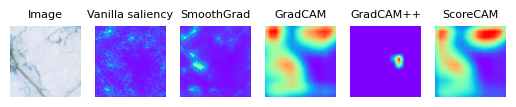

In [ ]:
# Render
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
ax1.imshow(raw_img)
ax1.axis('off')

ax2.imshow(saliency_map[0,:,:], cmap = "rainbow")
ax2.axis('off')

ax3.imshow(saliency_map1[0,:,:], cmap = "rainbow")
ax3.axis('off')

ax4.imshow(cam1[0,:,:], cmap = "rainbow")
ax4.axis('off')

ax5.imshow(cam2[0,:,:], cmap = "rainbow")
ax5.axis('off')

ax6.imshow(cam3[0,:,:], cmap = "rainbow")
ax6.axis('off')

ax1.set_title('Image', size = 8)
ax2.set_title('Vanilla saliency', size = 8)
ax3.set_title('SmoothGrad', size = 8)
ax4.set_title('GradCAM', size = 8)
ax5.set_title('GradCAM++', size = 8)
ax6.set_title('ScoreCAM', size = 8)

plt.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, re.sub('.jpg', '_saliencies.svg', img_file)), dpi=300, pad_inches = 0, transparent = True)

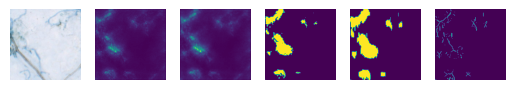

In [ ]:
sal_img = saliency_map1[0,:,:]
sal_img = sal_img * 255
sal_img = sal_img.astype(np.uint8)
# sal_img.shape
# sal_img_thresh = np.copy(sal_img)
# sal_img_thresh[sal_img_thresh < 30] = 0
# plt.imshow(sal_img_thresh, cmap = 'viridis')
# plt.colorbar()

img_blur = cv2.GaussianBlur(sal_img, (3,3), cv2.BORDER_DEFAULT)
ret,img1 = cv2.threshold(img_blur,0,255, cv2.THRESH_OTSU)
#ret,img1 = cv2.threshold(img_blur, 35, 255, cv2.THRESH_BINARY)
#ret,img1 = cv2.threshold(img,0,255, cv2.THRESH_OTSU)
img2 = cv2.dilate(img1, (5,5), iterations = 10)
#img2 = cv2.erode(img1, (5,5), iterations = 20)

# Skeletonization from (https://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html)

img = img2
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)

element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False

while(not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
ax1.imshow(raw_img)
ax1.axis('off')

ax2.imshow(sal_img)
ax2.axis('off')

ax3.imshow(img_blur)
ax3.axis('off')

ax4.imshow(img1)
ax4.axis('off')

ax5.imshow(img2)
ax5.axis('off')

ax6.imshow(skel)
ax6.axis('off')


plt.savefig(os.path.join('/content/drive/MyDrive/PhD/TrypanBlue/', outputdirectory, re.sub('.jpg', '_skeletonization.svg', img_file)), dpi=300, pad_inches = 0, transparent = True)